In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.nn.functional as F
import cv2
import numpy as np
import os, random,sys

In [2]:
path = '/content/lfw'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/lfw.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

In [6]:
# Check for CUDA GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA device not found.")


Using CUDA device: Tesla T4


torch.Size([250, 250, 3])


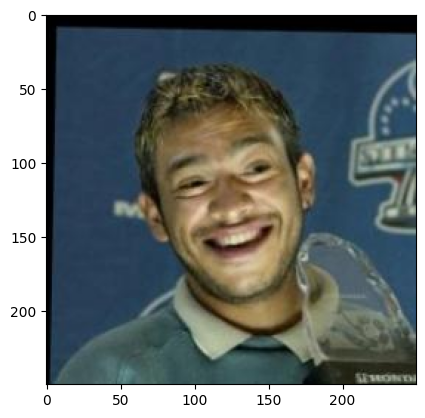

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

The transition from an Autoencoder (AE) to a Variational Autoencoder (VAE) involves key differences in their applications, architecture, and loss function. I have discussed these aspects with reference to my models below -

### Applications
- **Autoencoders (AE)**: Primarily used for tasks like noise reduction, dimensionality reduction, and feature extraction. AEs learn to compress data into a lower-dimensional space and then reconstruct it back to its original form.
- **Variational Autoencoders (VAE)**: Apart from the applications of AEs, VAEs are also used for generative tasks. They can generate new data instances that are similar to the training data, making them suitable for image generation, semi-supervised learning, and anomaly detection.

### Architecture
- **AE Architecture**: Consists of an encoder that compresses the input into a latent space and a decoder that reconstructs the input from the latent representation. The `ImprovedAE` class that I developed in the prevous assignment has a structure with convolutional layers in the encoder and transposed convolutional layers in the decoder.
- **VAE Architecture**: Similar to AEs in having an encoder and a decoder, but with a crucial difference. The encoder in a VAE doesn't output a fixed vector in the latent space but instead outputs a distribution (represented by mean `mu` and variance `logvar`). The `VAE` class developed below  has an encoder that outputs `mu` and `logvar`, and the `reparameterize` method samples from this distribution.

### Loss Function
- **AE Loss Function**: Typically uses a reconstruction loss like Mean Squared Error (MSE) or Structural Similarity Index (SSIM). Your AE model uses a combination of MSE and SSIM. This loss measures how well the reconstructed output matches the original input.
- **VAE Loss Function**: Consists of two parts: the reconstruction loss (like in AEs) and the Kullback-Leibler (KL) divergence. The KL divergence regularizes the encoder by penalizing the divergence of the learned distribution from a prior distribution (often a standard normal distribution). The `loss_function` for your VAE model combines Binary Cross-Entropy (BCE) as the reconstruction loss and KL divergence for regularization.

The transition from AE to VAE involves adding a probabilistic twist to the latent space representation and a corresponding change in the loss function to include a term that regularizes this probabilistic representation. This change allows VAEs to not only compress and reconstruct data but also to generate new data instances that resemble the training data.

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder with layers and filters
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self._calculate_flat_size((3, 250, 250))

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc21 = nn.Linear(512, 10)
        self.fc22 = nn.Linear(512, 10)

        # Decoder
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 32*63*63)
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)

    def _calculate_flat_size(self, shape):
        with torch.no_grad():
            x = torch.ones(1, *shape)
            x = self.conv1(x)
            x = self.conv2(x)
            self._to_linear = x.view(-1).shape[0]

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 32, 63, 63)  # Adjusted reshape
        z = F.relu(self.deconv1(z))
        z = self.deconv2(z)  # Final layer outputs 3 channels
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Generating New Data: A Dive into VAE's Latent Space Mechanics

The VAE's standout feature is its ability to generate novel data instances, a process rooted in its unique handling of the latent space:

1. **Concept of Reparameterization**:
   In VAEs, reparameterization introduces a stochastic element essential for generative processes. It starts by transforming `logvar` into standard deviation (`std`). Then, a random noise vector `eps` is generated. The latent vector `z` is computed as `z = mu + eps * std`, effectively sampling from the distribution defined by `mu` and `logvar`.

2. **Sampling Novel Latent Vectors**:
   By varying `eps`, we can sample diverse points (`z`) from the latent space, each encoding different aspects of the data's distribution learned by the model.

3. **Latent to Concrete: Decoding New Instances**:
   Each sampled latent vector `z` is fed into the decoder. The decoder, adept at mapping latent representations back to the data space, generates new data instances that mirror the characteristics of the training set, yet are distinct in their specifics.



In [11]:
# Create an instance of the VAE class
model = VAE().to(device)

# Assuming 'input_image' is your input tensor with the correct shape
# For demonstration, let's create a dummy input image
# Replace this with your actual image or a batch of images from your dataloader
# Prepare your input image and move it to the same device as the model
input_image = torch.randn(1, 3, 250, 250).to(device)  # Example shape

# Pass the image through the model
with torch.no_grad():
    model.eval()
    reconstructed_image, mu, logvar = model(input_image)

# Print the shapes of the outputs
print("Shape of mu (encoder's output):", mu.shape)
print("Shape of logvar (encoder's output):", logvar.shape)
print("Shape of reconstructed image (decoder's output):", reconstructed_image.shape)
# Sample new latent vectors
with torch.no_grad():
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    new_latent_samples = mu + eps * std

    # Use the decoder to generate new images
    generated_images = model.decode(new_latent_samples)

# Print the shape of the generated images
print("Shape of generated images:", generated_images.shape)


Shape of mu (encoder's output): torch.Size([1, 10])
Shape of logvar (encoder's output): torch.Size([1, 10])
Shape of reconstructed image (decoder's output): torch.Size([1, 3, 250, 250])
Shape of generated images: torch.Size([1, 3, 250, 250])


### Verification of forward pass

We can see from the above output that the shape of the generated images is matching the expected output dimensions. This indicates that the decoder is reshaping the latent vectors back into the dimensions of the original input data.

In [11]:
# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 128169591


### Understanding the VAE Loss Function

The VAE's loss function is ingeniously crafted to serve dual purposes, closely tied to its twin characteristics of accurate data reconstruction and effective data generation:

1. **Reconstruction Loss**:
   - **What it Achieves**: This component is designed to fine-tune the VAE's ability to faithfully reconstruct input data. It quantitatively measures how well the output mirrors the input.
   - **Mechanism**: Depending on the data type (binary or continuous), this loss may take the form of Binary Cross-Entropy or Mean Squared Error. It's akin to placing the original and reconstructed data side by side and spotting differences, pixel by pixel in the case of images.
   - **Significance**: The smaller the reconstruction loss, the more adept the model is at capturing and reflecting the key attributes of the input data.

2. **Kullback-Leibler (KL) Divergence**:
   - **What it Achieves**: The KL Divergence is essentially the VAE's tool for shaping its latent space. It encourages the model to align its learned latent data distribution with a predefined, typically standard normal, distribution.
   - **Mechanism**: This term assesses how much the model's latent distribution strays from the desired distribution. It acts as a regularizer, ensuring the latent space isn't disorderly or overly dispersed.
   - **Significance**: A well-regulated latent space, thanks to the KL Divergence, is crucial for the VAE's generative aspect. It ensures that the latent space is not just a random collection of points but a meaningful and interpretable space from which new, coherent data instances can be sampled.

In [12]:
def loss_function(recon_x, x, mu, logvar):
    # Calculate the Binary Cross-Entropy (BCE) between the input and the reconstructed output
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Kullback-Leibler Divergence (KLD) to regularize the latent space
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is the sum of BCE and KLD
    return BCE + KLD


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [16]:
epochs = 10

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Using the loss function
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()


    average_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch} Average loss: {average_loss}')



Epoch: 1 Average loss: 101347.63687013673
Epoch: 2 Average loss: 100867.10413046763
Epoch: 3 Average loss: 100529.15923169903
Epoch: 4 Average loss: 100306.25275742238
Epoch: 5 Average loss: 100084.13432990859
Epoch: 6 Average loss: 99904.68267923246
Epoch: 7 Average loss: 99751.27816914709
Epoch: 8 Average loss: 99601.70508801087
Epoch: 9 Average loss: 99451.81970990406
Epoch: 10 Average loss: 99342.86241217799


### Troubleshooting Strategies for Non-Decreasing Loss

In my case, the model showed appropriate training behavior since the loss values are gradually decreasing. However, if one notes that the loss isn't decreasing across epochs, the following techniques can be considered to fix the training process:

1. **Optimize Learning Rate**: The learning rate is pivotal in model training. If it's too high, the model might skip over minima; if too low, the model might not converge efficiently. Experiment with different learning rates.

2. **Evaluate Model Architecture**: Analyze whether the model's complexity is appropriate for the task at hand. A very complex model might overfit, while an overly simple model might underperform.

3. **Data Preprocessing Check**: Proper data preparation is crucial. Ensure the data is correctly normalized and preprocessed.

4. **Tune the Loss Function**: In VAEs, balancing the reconstruction loss and KL divergence is key. Adjusting their relative weights can sometimes yield better results.

5. **Experiment with Batch Sizes**: Smaller batch sizes provide more frequent weight updates, while larger batches offer stability. Finding the right balance is essential.

6. **Regularization Techniques**: Implement or adjust methods like dropout to prevent overfitting, if necessary.

7. **Switch Optimizers**: While Adam is versatile, sometimes a simple SGD with momentum, or another optimizer, might work better depending on the specific scenario.

8. **Weight Initialization**: The starting point can affect training efficiency. Experiment with different weight initialization methods.

9. **Debugging the Model and Data Pipeline**: Ensure there are no hidden bugs or issues in your model architecture or data loading processes.

10. **Implement Early Stopping**: This technique halts training when the model begins to overfit or fails to improve, preserving the best state achieved.

By systematically exploring these strategies, we can identify and rectify the root causes of stagnant or increasing loss values during the training of the VAE.

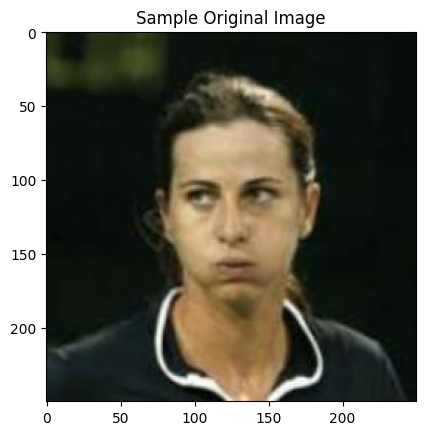

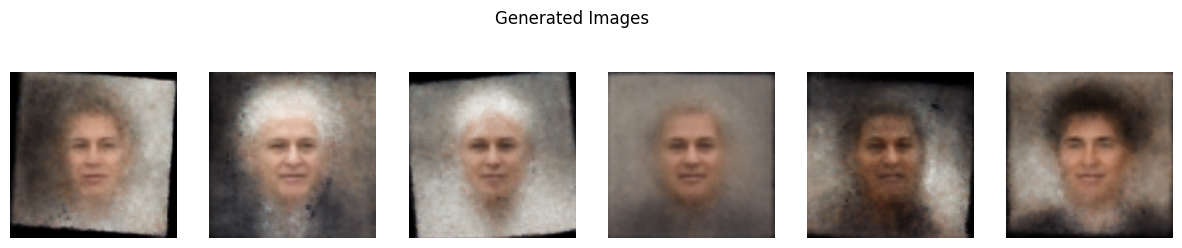

In [20]:
import random

# Set the model to evaluation mode
model.eval()

# Select and display a random image from the dataset
with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader) - 1):
            original_img = data[0].to(device)
            plt.imshow(original_img.cpu().permute(1, 2, 0))
            plt.title("Sample Original Image")
            plt.show()
            break

            # Adjust the size of the latent vector to match the input size of the decoder
    random_latent_vectors = torch.randn(64, 10).to(device)  # Changed from 20 to 10
    generated_imgs = model.decode(random_latent_vectors).cpu()

    # Displaying a subset of generated images
    fig, axs = plt.subplots(1, 6, figsize=(15, 3))  # Adjust the layout as needed
    for ax, img in zip(axs, generated_imgs[:6]):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.suptitle("Generated Images")
    plt.show()


**Original vs Generated Images:** The original image appears to be of a person's face with clear features, while the generated images show variations in facial features, indicating that the model has learned to vary certain attributes.

**Detail and Clarity:** The generated images seem to lack some detail and clarity compared to the original image. This could be due to the model not capturing all the intricacies of the input data or it could be a result of the inherent blurriness introduced by the VAE's generative process.

**Diversity of Output:** The generated images display a range of facial features and hair styles. This suggests that the latent space has encoded various aspects of the data and the model is capable of sampling and decoding diverse points from this space.

**Fidelity to Input Data:** While the generated images are recognizable as faces, they do not seem to replicate the exact appearance of the original image. This is typical for VAEs, which are designed to generate new content that is similar but not identical to the input data.

**Color and Contrast:** The color and contrast in the generated images are muted compared to the original. This might indicate that the model's decoder could be improved to better capture the color distribution of the input data.

In conclusion, the model is capable of generating new images that maintain the basic structure and components of a face. However, there is room for improvement in terms of clarity, detail, and color fidelity. Further training, hyperparameter tuning, or architectural changes might be required to enhance the quality of the generated images.


Note to the grader - Fine tuning the model wasn't possible in this case since the task is resource intensive and all of the RAM got used up when I just tried to add one layer in encoder and decoder each.